## 1. Initial Setup

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install "yfinance[nospam]"

In [4]:
import yfinance as yf
import pandas as pd
import time
import math
import os
from datetime import datetime
from requests import Session
from requests_cache import CacheMixin, SQLiteCache
from requests_ratelimiter import LimiterMixin, MemoryQueueBucket
from pyrate_limiter import Duration, RequestRate, Limiter

In [9]:
# Read file containing list of tickers:
DATADIR = "/content/gdrive/MyDrive"

# specifying the zip file name
DATAFILE = "asx_ticker_universe.xlsx"

datafile_path = os.path.join(DATADIR, DATAFILE)

with pd.ExcelFile(datafile_path) as xls:
  df = pd.read_excel(xls, "Sheet1")

ticker_list = df["Ticker"].to_list()
ticker_2019_23 = df[["Ticker", "Company name", "GICs industry group"]]

In [6]:
class CachedLimiterSession(CacheMixin, LimiterMixin, Session):
    pass

session = CachedLimiterSession(
    limiter=Limiter(RequestRate(2, Duration.SECOND*5)),  # max 2 requests per 5 seconds
    bucket_class=MemoryQueueBucket,
    backend=SQLiteCache("yfinance.cache"),
)

session.headers['User-agent'] = 'asx_exp/1.0'

In [7]:
def comp_hist(ticker: str):

  """
  - This is a function to compute the Diluted EPS and Book Value per Share (BPS)
  - Inputs: tickers (str)
  - Outputs: dictionaries of Diluted EPS and Book Value per Share (BPS)
  """

  comp_data = yf.Ticker(ticker = ticker, session=session)

  # Get financial data
  DilutedEPS = dict(comp_data.get_financials().loc["DilutedEPS"])

  BVPS = ["%.2f" % float(n/m) if math.isnan(m) == False and math.isnan(n) == False else float("nan") for n, m in zip(comp_data.balancesheet.loc["Tangible Book Value"], comp_data.balancesheet.loc["Ordinary Shares Number"])]
  BPS = dict(zip(comp_data.balancesheet.loc["Tangible Book Value"].keys(), BVPS))

  n_yrs = DilutedEPS.keys()

  DilutedEPS_dict = {}
  BPS_dict = {}
  yr_idx = []

  for n_yr in n_yrs:
    fin_yr = datetime.strftime(n_yr, '%Y')
    yr_idx.append(fin_yr)

    if fin_yr == '2023':
      DilutedEPS_2023 = DilutedEPS[n_yr]
      BPS_2023 = BPS[n_yr]

      DilutedEPS_dict[fin_yr] = DilutedEPS_2023
      BPS_dict[fin_yr] = BPS_2023

    elif fin_yr == '2022':
      DilutedEPS_2022 = DilutedEPS[n_yr]
      BPS_2022 = BPS[n_yr]

      DilutedEPS_dict[fin_yr] = DilutedEPS_2022
      BPS_dict[fin_yr] = BPS_2022

    elif fin_yr == '2021':
      DilutedEPS_2021 = DilutedEPS[n_yr]
      BPS_2021 = BPS[n_yr]

      DilutedEPS_dict[fin_yr] = DilutedEPS_2021
      BPS_dict[fin_yr] = BPS_2021

    elif fin_yr == '2020':
      DilutedEPS_2020 = DilutedEPS[n_yr]
      BPS_2020 = BPS[n_yr]

      DilutedEPS_dict[fin_yr] = DilutedEPS_2020
      BPS_dict[fin_yr] = BPS_2020

    else:
      DilutedEPS_2019 = DilutedEPS[n_yr]
      BPS_2019 = BPS[n_yr]

      DilutedEPS_dict[fin_yr] = DilutedEPS_2019
      BPS_dict[fin_yr] = BPS_2019

    for yr in ["2023", "2022", "2021", "2020", "2019"]:
      if yr in yr_idx:
        pass
      else:
        DilutedEPS_dict[yr] = float("nan")
        BPS_dict[yr] = float("nan")

  return DilutedEPS_dict, BPS_dict

## 2. Download financials and share prices

In [ ]:
ticker_PE_dict = {}
ticker_PB_dict = {}
ticker_adj_price_dict = {}

i = 1

for ticker in ticker_list:

  i = i + 1

  start_2019 = "2019-09-01"
  end_2019 = "2019-09-07"
  start_2020 = "2020-09-01"
  end_2020 = "2020-09-07"
  start_2021 = "2021-09-01"
  end_2021 = "2021-09-07"
  start_2022 = "2022-09-01"
  end_2022 = "2022-09-07"
  start_2023 = "2023-09-01"
  end_2023 = "2023-09-07"

  # get historical market - closed price data
  DilutedEPS_2019_23, BPS_2019_23 = comp_hist(ticker = ticker)

  avg_price_2019 = yf.download(ticker, start = start_2019, end = end_2019, session=session)["Close"].mean()
  avg_price_2020 = yf.download(ticker, start = start_2020, end = end_2020, session=session)["Close"].mean()
  avg_price_2021 = yf.download(ticker, start = start_2021, end = end_2021, session=session)["Close"].mean()
  avg_price_2022 = yf.download(ticker, start = start_2022, end = end_2022, session=session)["Close"].mean()
  avg_price_2023 = yf.download(ticker, start = start_2023, end = end_2023, session=session)["Close"].mean()

  avg_price = [avg_price_2023, avg_price_2022, avg_price_2021, avg_price_2020, avg_price_2019]

  avg_adj_price_2019 = yf.download(ticker, start = start_2019, end = end_2019, session=session)["Adj Close"].mean()
  avg_adj_price_2020 = yf.download(ticker, start = start_2020, end = end_2020, session=session)["Adj Close"].mean()
  avg_adj_price_2021 = yf.download(ticker, start = start_2021, end = end_2021, session=session)["Adj Close"].mean()
  avg_adj_price_2022 = yf.download(ticker, start = start_2022, end = end_2022, session=session)["Adj Close"].mean()
  avg_adj_price_2023 = yf.download(ticker, start = start_2023, end = end_2023, session=session)["Adj Close"].mean()

  adj_avg_price = [avg_adj_price_2019, avg_adj_price_2020, avg_adj_price_2021, avg_adj_price_2022, avg_adj_price_2023]

  # PE, PB ratio
  PE = ["%.2f" % float(i / j) if math.isnan(j) == False and j != 0 else float("nan") for i, j in zip(avg_price, DilutedEPS_2019_23.values())]
  PB = ["%.2f" % float(float(i) / float(j)) if math.isnan(float(j)) == False and float(j) != 0 else float("nan") for i, j in zip(avg_price, BPS_2019_23.values())]

  ticker_PE_dict[ticker] = PE
  ticker_PB_dict[ticker] = PB
  ticker_adj_price_dict[ticker] = adj_avg_price

  time.sleep(2)

  # Stop downloading after every 30 stocks
  if i % 30 == 0:
      time.sleep(10)

In [296]:
df_PE_list = pd.DataFrame.from_dict(ticker_PE_dict, orient='index')
df_PB_list = pd.DataFrame.from_dict(ticker_PB_dict, orient='index')

In [298]:
df_PE_list.columns = ["2023", "2022", "2021", "2020", "2019"]
df_PB_list.columns = ["2023", "2022", "2021", "2020", "2019"]

## 3. Set up price table

In [10]:
# Review ticker table (This table only contains the company name and GICs, and it does not contain any stock prices)
ticker_2019_23

,Ticker,Company name,GICs industry group
0,BHP.AX,BHP GROUP LIMITED,Materials
1,CBA.AX,COMMONWEALTH BANK OF AUSTRALIA.,Banks
2,CSL.AX,CSL LIMITED,"Pharmaceuticals, Biotechnology & Life Sciences"
3,NAB.AX,NATIONAL AUSTRALIA BANK LIMITED,Banks
4,WBC.AX,WESTPAC BANKING CORPORATION,Banks
...,...,...,...
95,NWL.AX,NETWEALTH GROUP LIMITED,Financial Services
96,FLT.AX,FLIGHT CENTRE TRAVEL GROUP LIMITED,Consumer Services
97,PMV.AX,PREMIER INVESTMENTS LIMITED,Consumer Discretionary Distribution & Retail
98,CGF.AX,CHALLENGER LIMITED,Financial Services


In [ ]:
# Set Ticker as index for ticker_price_2019_23
ticker_des_2019_23 = ticker_2019_23.set_index("Ticker")

# Create a price table containing all adjusted prices of Tickers in the list
ticker_price_tbl = pd.DataFrame.from_dict(ticker_adj_price_dict, orient='index', columns=['2019', '2020', '2021', '2022', '2023'])

# Add Ticker column to price table
ticker_price_tbl["Ticker"] = ticker_price_tbl.index

# Combined tables
ticker_combined_tbl = pd.concat([ticker_des_2019_23, ticker_price_tbl], axis = 1)

# Add Ticker column to price table
ticker_combined_tbl["Ticker"] = ticker_combined_tbl.index

In [308]:
# Review combined table
ticker_combined_tbl

,Company name,GICs industry group,2019,2020,2021,2022,2023,Ticker
BHP.AX,BHP GROUP LIMITED,Materials,22.281055,24.530239,30.816143,34.430909,43.377886,BHP.AX
CBA.AX,COMMONWEALTH BANK OF AUSTRALIA.,Banks,66.340091,58.604923,91.779764,90.526388,99.901524,CBA.AX
CSL.AX,CSL LIMITED,"Pharmaceuticals, Biotechnology & Life Sciences",226.303192,271.863403,295.912201,287.737862,266.201172,CSL.AX
NAB.AX,NATIONAL AUSTRALIA BANK LIMITED,Banks,22.131163,14.845575,25.073814,27.865524,28.040582,NAB.AX
WBC.AX,WESTPAC BANKING CORPORATION,Banks,22.918514,14.345636,22.516206,19.403811,20.867162,WBC.AX
...,...,...,...,...,...,...,...,...
NWL.AX,NETWEALTH GROUP LIMITED,Financial Services,7.385206,13.840460,15.079068,12.325931,15.209501,NWL.AX
FLT.AX,FLIGHT CENTRE TRAVEL GROUP LIMITED,Consumer Services,41.935910,12.511033,17.027392,16.970412,20.369449,FLT.AX
PMV.AX,PREMIER INVESTMENTS LIMITED,Consumer Discretionary Distribution & Retail,12.936436,17.036819,26.006668,20.186319,25.311452,PMV.AX
CGF.AX,CHALLENGER LIMITED,Financial Services,5.802330,3.553822,5.927987,5.973654,6.356611,CGF.AX


## 4. Portfolio selection

In [13]:
# Define function for portfolio selection
def portfolio_selection(ticker_universe: pd.DataFrame) -> dict():

  """
  - This is a function to select stocks from investment universe
  - Inputs: ticker_universe (DataFrame): the DataFrame containing all tickers in the investment universe
  - Outputs: a dictionary of 10 stocks selected
  """

  port_selection = {}

  for fin_yr in ticker_universe.columns[1:]:

    # Filter out stocks with NaN metrics:
    df1 = ticker_universe.loc[~(ticker_universe[fin_yr].isna())]

    # Ranking stocks by metrics
    stock_ranking = df1.sort_values(by = [fin_yr])

    df2 = pd.to_numeric(stock_ranking[fin_yr])

    # Obtain top-10 stocks with lowest metrics
    port_selection[fin_yr] = df2[df2 > 0][0:10]

  return port_selection

In [14]:
# Select PE-based and PB-based portfolios
PE_port_selection = portfolio_selection(df_PE_list)
PB_port_selection = portfolio_selection(df_PB_list)

In [15]:
# 2019 data is not available, remove the column 2019
PE_port_selection_review = PE_port_selection
del PE_port_selection_review['2019']

In [16]:
# 2019 data is not available, remove the column 2019
PB_port_selection_review = PB_port_selection
del PB_port_selection_review['2019']

## Portfolio performance

In [19]:
# Define function to compute portfolio performances
def portfolio_performance(initial_investment_amt: int | float, port_selection: dict, ticker_combined_tbl: pd.DataFrame):

    """
    - This is a function to compute the performance of investment portfolio
    - Inputs:
      - initial_investment_amt (int | float): amount of initial investment
      - port_selection (dict): the dictionary of 10 stocks selected
      - ticker_combined_tbl (DataFrame): DataFrame of tickers and stock prices in the investment universe
    - Outputs:
      - portfolio_return: the return of investment portfolio over investment's time
      - annual_portfolio_return: the CAGR return of portfolio
      - portfolio_value_table: the data table contains portfolio values for each investment year.
    """

    port_yrs = list(port_selection.keys())
    allocated_amt_ratio = round(1 / len(port_selection[port_yrs[0]]), 1)

    port_yrs.reverse()
    port_yrs.append(str(int(port_yrs[-1]) + 1))

    portfolio_value_dict = dict()

    yearly_investment_amt = initial_investment_amt

    idx = 0

    for port_yr in port_yrs:

        idx = idx + 1

        portfolio_value_dict[port_yr] = yearly_investment_amt
        invested_amt = yearly_investment_amt * allocated_amt_ratio

        if idx < len(port_yrs):

            portfolio_value = []

            # Obtain the list of stocks in portfolio
            for stock in port_selection[port_yr].index:
                try:
                    # Stock price at investment time
                    stock_price = ticker_combined_tbl[ticker_combined_tbl["Ticker"] == stock][port_yr]

                    # stock price after 1 year since investment
                    stock_price_after1yr = ticker_combined_tbl[ticker_combined_tbl["Ticker"] == stock][str(int(port_yr) + 1)]

                    # value of investment after 1 year
                    investment_value = invested_amt * (stock_price_after1yr / stock_price)

                    # add each investment value to portfolio
                    portfolio_value.append(investment_value)

                except Exception as e:
                    raise e

            # total value of portfolio
            portfolio_value_after1yr = sum([float(i) for i in portfolio_value])

            yearly_investment_amt = portfolio_value_after1yr
            portfolio_value_dict[str(int(port_yr) + 1)] = portfolio_value_after1yr

    portfolio_value_table = pd.DataFrame.from_dict(portfolio_value_dict, orient='index', columns = ["Portfolio_value"])

    portfolio_value_2 = portfolio_value_dict["2023"]
    portfolio_value_1 = portfolio_value_dict["2020"]

    portfolio_return = round((portfolio_value_2 / portfolio_value_1 - 1)*100)
    annual_portfolio_return = pow((1 + portfolio_return/100), 1/(len(port_yrs) - 1)) - 1

    return portfolio_return, annual_portfolio_return, portfolio_value_table

In [20]:
# Compute performance of PE-based portfolio
PE_portfolio_return, PE_annual_portfolio_return, PE_portfolio_value_table  = portfolio_performance(initial_investment_amt = 100000, \
                                                                                          port_selection = PE_port_selection_review, \
                                                                                          ticker_combined_tbl= ticker_combined_tbl)

In [21]:
# Compute performance of PB-based portfolio
PB_portfolio_return, PB_annual_portfolio_return, PB_portfolio_value_table  = portfolio_performance(initial_investment_amt = 100000, \
                                                                                                  port_selection = PB_port_selection_review, \
                                                                                                  ticker_combined_tbl= ticker_combined_tbl)

## 5. Portfolio performance chart

In [22]:
import matplotlib.pyplot as plt

In [28]:
# Define function for index performance
def index_performance(ticker: str, investment_amt: int | float):

  """
  This is a function to compute the index performance
  - Inputs:
    - ticker (str): ticker of index
    - investment_amt (int | float): the initial investment value
  - Outputs:
    - mkt_index (DataFrame): index values for each investment year
  """

  start_2020 = "2020-09-01"
  end_2020 = "2020-09-07"
  start_2021 = "2021-09-01"
  end_2021 = "2021-09-07"
  start_2022 = "2022-09-01"
  end_2022 = "2022-09-07"
  start_2023 = "2023-09-01"
  end_2023 = "2023-09-07"

  # Download index price
  mkt_avg_adj_price_2020 = yf.download(ticker, start = start_2020, end = end_2020, session=session)["Adj Close"].mean()
  mkt_avg_adj_price_2021 = yf.download(ticker, start = start_2021, end = end_2021, session=session)["Adj Close"].mean()
  mkt_avg_adj_price_2022 = yf.download(ticker, start = start_2022, end = end_2022, session=session)["Adj Close"].mean()
  mkt_avg_adj_price_2023 = yf.download(ticker, start = start_2023, end = end_2023, session=session)["Adj Close"].mean()

  # Compute returns
  return_20_21 = mkt_avg_adj_price_2021 /mkt_avg_adj_price_2020
  return_21_22 = mkt_avg_adj_price_2022 / mkt_avg_adj_price_2021
  return_22_23 = mkt_avg_adj_price_2023 / mkt_avg_adj_price_2022

  # Create dataframe containing investment values over investment time
  mkt_index_dict = {'2020' : investment_amt, \
                    '2021' : (investment_amt * return_20_21), \
                    '2022' : (investment_amt * return_20_21 * return_21_22), \
                    '2023' : (investment_amt * return_20_21 * return_21_22 * return_22_23)}

  mkt_index = pd.DataFrame.from_dict(mkt_index_dict, orient='index', columns = ["Index"])

  return mkt_index


### S&P/ASX 100

In [ ]:
mkt_index100 = index_performance(ticker = "^ATOI", investment_amt = 100000)

### S&P/ASX 200

In [ ]:
mkt_index200 = index_performance(ticker = "^AXJO", investment_amt = 100000)

### ALL ORDINARIES

In [ ]:
mktAll_index = index_performance(ticker = "^AORD", investment_amt = 100000)

### Portfolio performance chart

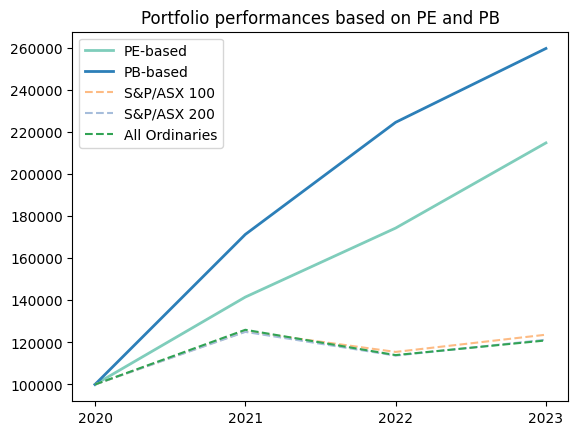

In [35]:
# Portfolio performance chart
fig, ax = plt.subplots()

ax.plot(PE_portfolio_value_table.index, PE_portfolio_value_table["Portfolio_value"], color = "#7fcdbb" , linewidth=2.0, label = "PE-based")
ax.plot(PB_portfolio_value_table.index, PB_portfolio_value_table["Portfolio_value"], color = "#2c7fb8", linewidth=2.0, label = "PB-based")
ax.plot(mkt_index100.index, mkt_index100["Index"], '--', color = "#fdbb84", label = "S&P/ASX 100")
ax.plot(mkt_index200.index, mkt_index200["Index"], '--', color = "#a6bddb", label = "S&P/ASX 200")
ax.plot(mktAll_index.index, mktAll_index["Index"], '--', color = "#31a354", label = "All Ordinaries")

plt.legend()
plt.title("Portfolio performances based on PE and PB")

# Save the chart
# plt.savefig(os.path.join(DATADIR, "Portfolio_ASX.png"))

plt.show()

-----

## Build an web application quickly with Gradio

Create an application to compute and visualize portfolio performances, using Gradio.

In [ ]:
# Setup
!pip install gradio

In [47]:
import gradio as gr

In [66]:
# Define chart function
def performance_chart(input: "str"):

    """
    This is the function to plot the portfolio and index performances
    - Inputs:
      - input (str): either 'PE-based', 'PB-based' or All (both PE-based and PB-based)
    - Outputs:
      - performance chart of selected portfolio and indices
      - return_tbl: the table containing 2020-23 CAGR of portfolio and indices
    """

    # Portfolio performance chart
    fig, ax = plt.subplots()

    if input == "PE-based":
      ax.plot(PE_portfolio_value_table.index, PE_portfolio_value_table["Portfolio_value"], color = "#7fcdbb" , linewidth=2.0, label = "PE-based")
      ax.plot(mkt_index100.index, mkt_index100["Index"], '--', color = "#fdbb84", label = "S&P/ASX 100")
      ax.plot(mkt_index200.index, mkt_index200["Index"], '--', color = "#a6bddb", label = "S&P/ASX 200")
      ax.plot(mktAll_index.index, mktAll_index["Index"], '--', color = "#31a354", label = "All Ordinaries")

      plt.legend()
      plt.title("Portfolio performances based on PE")

      PE_portfolio_return = round((pow((float(PE_portfolio_value_table.loc['2023']) / float(PE_portfolio_value_table.loc['2020'])), 1/3) - 1) * 100, 2)
      mkt_index100_return = round((pow((mkt_index100.loc['2023'] / mkt_index100.loc['2020']), 1/3) - 1) * 100, 2)
      mkt_index200_return = round((pow((mkt_index200.loc['2023'] / mkt_index200.loc['2020']), 1/3) - 1) * 100, 2)
      mktAll_index_return = round((pow((mktAll_index.loc['2023'] / mktAll_index.loc['2020']), 1/3) - 1) * 100, 2)

      return_tbl = pd.DataFrame({"PE-based" : PE_portfolio_return,
                                 "S&P/ASX 100, %" : mkt_index100_return,
                                 "S&P/ASX 200,%" : mkt_index200_return,
                                 "All Ordinaries, %" : mktAll_index_return})

    elif input == "PB-based":

      ax.plot(PB_portfolio_value_table.index, PB_portfolio_value_table["Portfolio_value"], color = "#2c7fb8", linewidth=2.0, label = "PB-based")
      ax.plot(mkt_index100.index, mkt_index100["Index"], '--', color = "#fdbb84", label = "S&P/ASX 100")
      ax.plot(mkt_index200.index, mkt_index200["Index"], '--', color = "#a6bddb", label = "S&P/ASX 200")
      ax.plot(mktAll_index.index, mktAll_index["Index"], '--', color = "#31a354", label = "All Ordinaries")

      plt.legend()
      plt.title("Portfolio performances based on PB")

      PB_portfolio_return = round((pow((float(PB_portfolio_value_table.loc['2023']) / float(PB_portfolio_value_table.loc['2020'])), 1/3) - 1) * 100, 2)
      mkt_index100_return = round((pow((mkt_index100.loc['2023'] / mkt_index100.loc['2020']), 1/3) - 1) * 100, 2)
      mkt_index200_return = round((pow((mkt_index200.loc['2023'] / mkt_index200.loc['2020']), 1/3) - 1) * 100, 2)
      mktAll_index_return = round((pow((mktAll_index.loc['2023'] / mktAll_index.loc['2020']), 1/3) - 1) * 100, 2)

      return_tbl = pd.DataFrame({"PB-based, %" : PB_portfolio_return,
                                 "S&P/ASX 100, %" : mkt_index100_return,
                                 "S&P/ASX 200,%" : mkt_index200_return,
                                 "All Ordinaries, %" : mktAll_index_return})

    else:

      ax.plot(PE_portfolio_value_table.index, PE_portfolio_value_table["Portfolio_value"], color = "#7fcdbb" , linewidth=2.0, label = "PE-based")
      ax.plot(PB_portfolio_value_table.index, PB_portfolio_value_table["Portfolio_value"], color = "#2c7fb8", linewidth=2.0, label = "PB-based")
      ax.plot(mkt_index100.index, mkt_index100["Index"], '--', color = "#fdbb84", label = "S&P/ASX 100")
      ax.plot(mkt_index200.index, mkt_index200["Index"], '--', color = "#a6bddb", label = "S&P/ASX 200")
      ax.plot(mktAll_index.index, mktAll_index["Index"], '--', color = "#31a354", label = "All Ordinaries")

      plt.legend()
      plt.title("Portfolio performances based on PE and PB")

      PE_portfolio_return = round((pow((float(PE_portfolio_value_table.loc['2023']) / float(PE_portfolio_value_table.loc['2020'])), 1/3) - 1) * 100, 2)
      PB_portfolio_return = round((pow((float(PB_portfolio_value_table.loc['2023']) / float(PB_portfolio_value_table.loc['2020'])), 1/3) - 1) * 100, 2)
      mkt_index100_return = round((pow((mkt_index100.loc['2023'] / mkt_index100.loc['2020']), 1/3) - 1) * 100, 2)
      mkt_index200_return = round((pow((mkt_index200.loc['2023'] / mkt_index200.loc['2020']), 1/3) - 1) * 100, 2)
      mktAll_index_return = round((pow((mktAll_index.loc['2023'] / mktAll_index.loc['2020']), 1/3) - 1) * 100, 2)

      return_tbl = pd.DataFrame({"PE-based, %" : PE_portfolio_return,
                                 "PB-based, %" : PB_portfolio_return,
                                 "S&P/ASX 100, %" : mkt_index100_return,
                                 "S&P/ASX 200,%" : mkt_index200_return,
                                 "All Ordinaries, %" : mktAll_index_return})

    return plt.gcf(), return_tbl


In [ ]:
# Create and Run the App
app = gr.Interface(
                    fn=performance_chart,
                    inputs=[gr.Textbox(placeholder = "Please type in 'PE-based' or 'PB-based' or 'All'",
                                      label = "Portfolio selection")],
                    outputs=[gr.Plot(label = "Portfolio chart"), gr.Dataframe(row_count = (1, 'dynamic'), label = "2020-23 CAGR summary")],
                    )

app.launch()